In [18]:
import pytesseract
from PIL import Image
from pdf2image.pdf2image import convert_from_path
import psycopg2
import cv2
import os
from datetime import datetime
from collections import Counter
import shutil
import numpy as np

In [2]:
# Replace these with your database credentials
db_config = {
    'dbname': 'data',
    'user': 'adrien',
    'password': 'adrien9583!',
    'host': 'localhost',
    'port': '5432'
}

In [3]:
def definition_of_tags(text):
    words = text.split()
    tags_and_words = {
        "règlement écrit": ["stationnement", "surface", "plancher", "zone", "occupations", "utilisations", "sol", "article"],
        "zonage": ["zone", "stationnement", "occupations", "utilisations"],
        "padd": ["developpement", "services", "secteurs", "protéger", "maitriser", "trame", "préserver", "améliorer", "ville-center", "reconquete", "zones", "équipements", "urbain", "padd","espaces","maitriser"],
        "Arrêté municipal/préfectoral/départemental/régional": ["vu","code","L.","R.","arrété","présent","article","définition","loi"]
    }

    stop_words = []
    with open("stop_words.txt", "r") as file:
        for line in file:
            word = line.strip()
            if word:
                stop_words.append(word)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    word_counts = Counter(filtered_words)
    top_words = word_counts.most_common(5)

    # Initialize a list and a set to store tagged words
    tagged_words = []
    unique_tagged_words = set()

    # Initialize dictionaries to store word counts and tag counts
    word_counts = {}
    tag_counts = {}
    tagged_words_by_tag = {}

    # Iterate through words and apply tags based on word lists
    for word in words:
        for tag, word_list in tags_and_words.items():
            if word.lower() in word_list:
                tagged_word = (word, tag)
                if tag not in tagged_words_by_tag:
                    tagged_words_by_tag[tag] = []
                tagged_words_by_tag[tag].append(tagged_word)
                word_counts[word] = word_counts.get(word, 0) + 1
                tag_counts[tag] = tag_counts.get(tag, 0) + 1

    # Calculate the total percentage for each tag and store in a dictionary
    tag_percentages = {}
    total_percentage = 0
    for tag, tagged_words in tagged_words_by_tag.items():
        total_count_for_tag = tag_counts[tag]
        tag_percentage = sum(
            word_counts[word] / total_count_for_tag * 100 for word, _ in tagged_words)
        tag_percentages[tag] = tag_percentage
        total_percentage += tag_percentage

    if total_percentage == 0:
        return []
    scaling_factor = 100 / total_percentage
    for tag in tag_percentages:
        tag_percentages[tag] *= scaling_factor
    results = []
    for tag, normalized_percentage in tag_percentages.items():
        results.append(tag)
        # print(f"Tag: {tag} ({normalized_percentage}%)")

    return top_words

In [32]:
def deskew(image):
    # Calculate the skew angle and deskew the image
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def preprocess_image(image):
    # Apply image preprocessing techniques for improved OCR accuracy
    image_to_ocr = cv2.imread(image)
    # Convert to grayscale
    gray_img = cv2.cvtColor(image_to_ocr, cv2.COLOR_BGR2GRAY)
    # Apply thresholding
    _, preprocessed_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # Remove noise
    preprocessed_img = cv2.medianBlur(preprocessed_img, 3)
    # Deskew the image
    preprocessed_img = deskew(preprocessed_img)
    
    return preprocessed_img

def extract_txt_from_pdf(document_name, source):
    conn = psycopg2.connect(**db_config)
    cursor = conn.cursor()
    
    # Convert PDF to images with reduced memory usage
    temp_image_dir = 'temp_images'
    shutil.rmtree(temp_image_dir)
    os.makedirs(temp_image_dir, exist_ok=True)
    pages = convert_from_path(
        f'pdfs/{document_name}.pdf',
        dpi=300,
        thread_count=4,
        output_folder=temp_image_dir
    )

    pages_data = ""
    
    for i, page in enumerate(pages, start=0):
        # Save the page as a temporary image file
        temp_image_path = f"temp_images/temp_image_{i}.png"
        page.save(temp_image_path, "PNG")
        preprocessed_img = preprocess_image(temp_image_path) 
        extracted_text = pytesseract.image_to_string(preprocessed_img)
        pages_data = pages_data + '\n' + extracted_text
        
    cursor.execute(
    """INSERT INTO pdf_text (document_name,
        page_number,
        text_content,
        present_tags,
        source,
        upload_date,
        user_reading
    ) VALUES (%s, %s, %s, %s, %s, %s, %s)""", (document_name, len(pages), pages_data, ["undefined"], source, str(datetime.now()), False))
    
    conn.commit()
    cursor.close()
    conn.close()

In [33]:
# Example data
document_name = ["ZONE-Udr"]
present_tags = ['règlement', 'zone']
source = 'https://www.forcalqueiret.fr/?page_id=222831'
city_name = 'Forcalqueiret'

os.makedirs(f"pdfs/used_pdf/{city_name}", exist_ok=True)
for name in document_name:
    extract_txt_from_pdf(name, source)
    # shutil.move(f"pdfs/{name}.pdf", f"pdfs/used_pdf/{city_name}/{name}.pdf")
    # shutil.move(f"pdfs/{name}.pdf:Zone.Identifier", f"pdfs/used_pdf/{city_name}/{name}.pdf:Zone.Identifier")

In [27]:
conn = psycopg2.connect(**db_config)
cursor = conn.cursor()
cursor.execute("SELECT id, document_name, page_number, text_content FROM pdf_text ;" )
datas = cursor.fetchall() 
cursor.close()
conn.close()

import pandas as pd
df = pd.DataFrame(datas)
df['tags'] = None

for index, row in df.iterrows():
    df.at[index, 'tags'] = definition_of_tags(df.at[index, 3])

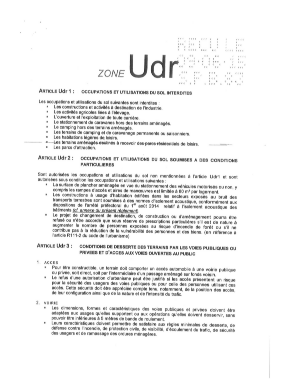

In [13]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the PPM image
image = Image.open('temp_images/1bc5bda7-ffe1-46a5-b021-05775de53b8b-3.ppm')

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()